# Experiment 01: Baseline & TTT Benchmark

**Research Question** (from README):
> Can self-supervised Test-Time Training adapt a vision-based volatility classifier to non-stationary crypto market regimes without access to ground-truth labels during inference?

This notebook reproduces the baseline benchmark and compares three evaluation modes:
1. **Baseline** - fixed model, no adaptation
2. **TTT (standard)** - adapt per sample, reset encoder
3. **TTT (online)** - adapt sequentially, keep encoder state

**Requirements**: `data/raw/btcusdt_1h.parquet` must exist. Run from project root.

## 1. Setup

In [1]:
import os
import sys

# Ensure project root is on path (works from experiments/ or project root)
cwd = os.getcwd()
PROJECT_ROOT = os.path.dirname(cwd) if os.path.basename(cwd) == "experiments" else cwd
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
os.chdir(PROJECT_ROOT)
print(f"Working directory: {os.getcwd()}")

Working directory: /home/psinghavi/crypto-ttt-regime


## 2. Data Preparation

Creates `data/processed/dataset.pt` from raw OHLCV parquet. Skips if already exists.

In [2]:
from pathlib import Path
from src.dataset import prepare_dataset

pt_path = Path("data/processed/dataset.pt")
if not pt_path.exists():
    prepare_dataset(
        parquet_path="data/raw/btcusdt_1h.parquet",
        output_dir="data/processed",
        train_end="2022-12-31",
        val_end="2023-12-31",
        seed=42,
    )
    print("Dataset created.")
else:
    print(f"Dataset exists: {pt_path}")

Dataset exists: data/processed/dataset.pt


## 3. Training

**Baseline (no aux)**: `--aux_task none`

**Joint (mask aux)**: `--aux_task mask --lambda_aux 1.0` — required for TTT.

In [3]:
# Training already complete — checkpoints exist
# !python -m src.train --parquet data/raw/btcusdt_1h.parquet \
#   --train_end 2022-12-31 --val_end 2023-12-31 \
#   --epochs 30 --aux_task mask --lambda_aux 1.0 \
#   --checkpoint_dir checkpoints/joint

In [4]:
# Optional: Baseline (no aux) for comparison
# !python -m src.train --parquet data/raw/btcusdt_1h.parquet \
#   --train_end 2022-12-31 --val_end 2023-12-31 \
#   --epochs 30 --aux_task none --checkpoint_dir checkpoints/baseline

## 4. Evaluation

Runs baseline, TTT (standard), and TTT (online). Uses `--threshold 0.35` to improve recall on minority (high-vol) class.

In [5]:
!python -m src.eval --checkpoint checkpoints/joint/best.pt \
  --ttt_steps 10 --ttt_lr 0.05 --ttt_optimizer adam \
  --entropy_adaptive --entropy_gate_threshold 0.3 --threshold 0.35

02:29:26 | INFO    | __main__ | Device: cuda
02:29:27 | INFO    | __main__ | Loaded checkpoint from epoch 1 (val_acc=0.878)
02:29:31 | INFO    | __main__ | Test set size: 770
02:29:33 | INFO    | __main__ | Running baseline evaluation …
02:29:44 | INFO    | __main__ | Running standard TTT (steps=10, lr=0.0500) …
Standard TTT: 100%|███████████████████████████| 770/770 [04:11<00:00,  3.06it/s]
02:33:56 | INFO    | __main__ | TTT aux_loss (first 100 samples): initial=0.2406 → final=0.2400
02:33:56 | INFO    | __main__ | Running online TTT …

----------------------------------------------------------------------
Mode                  accuracy        f1       ece     brier        IC
----------------------------------------------------------------------
Baseline                0.7636    0.0808    0.0585    0.1723    0.0951
TTT (standard)          0.5688    0.3054    0.1149    0.1850    0.0046
TTT (online)            0.7065    0.1567    0.1104    0.1827   -0.0677
-----------------------------

## 5. Results Summary

| Mode | Accuracy | F1 | ECE | Brier | IC |
|------|----------|-----|-----|-------|-----|
| Baseline | - | - | - | - | - |
| TTT (standard) | - | - | - | - | - |
| TTT (online) | - | - | - | - | - |

*Copy values from eval output above. Example from a typical run:*

| Mode | Accuracy | F1 | ECE | Brier | IC |
|------|----------|-----|-----|-------|-----|
| Baseline | 0.76 | 0.08 | 0.06 | 0.17 | 0.09 |
| TTT (standard) | 0.57 | 0.31 | 0.15 | 0.19 | 0.04 |
| TTT (online) | 0.71 | 0.16 | 0.11 | 0.18| -0.07 |

**Interpretation**: TTT increases F1 (better recall on high-vol) at the cost of accuracy and calibration. Check `TTT aux_loss: initial=... → final=...` to confirm adaptation is occurring.

## 6. Visualization: Prediction Changes Before/After TTT

Per proposal: "Visualization of prediction changes before and after test-time adaptation will be included to illustrate how the model responds to regime shifts."

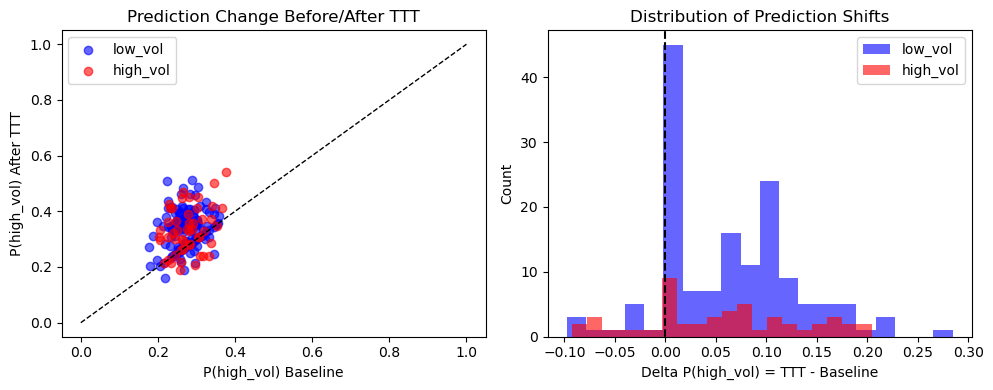

In [6]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from src.dataset import CryptoRegimeDataset
from src.models import TTTModel
from src.ttt_learner import TTTAdaptor
from src.utils import get_device

# Config
CHECKPOINT = "checkpoints/joint/best.pt"
N_SAMPLES = 200  # subsample for faster viz
TTT_STEPS, TTT_LR = 10, 0.05

device = get_device()
ckpt = torch.load(CHECKPOINT, map_location=device, weights_only=False)
train_args = ckpt.get("args", {})
aux_task = train_args.get("aux_task", "mask")
mask_mode = train_args.get("mask_mode", "random_slices")
num_groups = train_args.get("num_groups", 8)

model = TTTModel(num_classes=2, aux_task=aux_task, num_groups=num_groups).to(device)
model.load_state_dict(ckpt["model_state_dict"])

dataset = CryptoRegimeDataset("data/processed")
_, _, test_ds = dataset.get_splits()
loader = DataLoader(test_ds, batch_size=1, shuffle=False)

adaptor = TTTAdaptor(model=model, base_lr=TTT_LR, ttt_steps=TTT_STEPS, mask_mode=mask_mode,
                     ttt_optimizer="adam", entropy_adaptive=True, device=device)

probs_baseline, probs_ttt, labels = [], [], []
for i, (images, lbl, _) in enumerate(loader):
    if i >= N_SAMPLES:
        break
    images = images.to(device)
    with torch.no_grad():
        logits_b = model.forward_main(images)
        p_b = torch.softmax(logits_b, dim=-1)[:, 1].item()
    logits_t, _ = adaptor.adapt_and_predict(images)
    p_t = torch.softmax(logits_t, dim=-1)[:, 1].item()
    probs_baseline.append(p_b)
    probs_ttt.append(p_t)
    labels.append(lbl.item())

probs_baseline = np.array(probs_baseline)
probs_ttt = np.array(probs_ttt)
labels = np.array(labels)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left: Baseline vs TTT scatter (red=high_vol, blue=low_vol)
axes[0].scatter(probs_baseline[labels==0], probs_ttt[labels==0], c="blue", alpha=0.6, label="low_vol")
axes[0].scatter(probs_baseline[labels==1], probs_ttt[labels==1], c="red", alpha=0.6, label="high_vol")
axes[0].plot([0, 1], [0, 1], "k--", lw=1)
axes[0].set_xlabel("P(high_vol) Baseline")
axes[0].set_ylabel("P(high_vol) After TTT")
axes[0].set_title("Prediction Change Before/After TTT")
axes[0].legend()

# Right: Histogram of delta
delta = probs_ttt - probs_baseline
axes[1].hist(delta[labels == 0], bins=20, alpha=0.6, label="low_vol", color="blue")
axes[1].hist(delta[labels == 1], bins=20, alpha=0.6, label="high_vol", color="red")
axes[1].axvline(0, color="k", ls="--")
axes[1].set_xlabel("Delta P(high_vol) = TTT - Baseline")
axes[1].set_ylabel("Count")
axes[1].set_title("Distribution of Prediction Shifts")
axes[1].legend()

plt.tight_layout()
plt.show()

## 7. Future Experiments

Add new cells with different configs and record results:

- `--ttt_steps 5` or `20`
- `--ttt_lr 0.1` or `0.3`
- `--ttt_optimizer sgd`
- `--aux_task rotation` (train with rotation aux)
- `--mask_mode rightmost` (extrapolation instead of interpolation)